In [1]:
# === Imports
from __future__ import annotations
import os, glob, datetime as dt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from typing import Iterable
try:
    from scipy.spatial import cKDTree as KDTree
except Exception:
    KDTree = None  # scattered mapping will fall back to brute-force

import fiona

import matplotlib.pyplot as plt

In [2]:
# === Paths & basic config (edit these)
GPKG_PATH   = "/mnt/disk1/hydrofabric/nextgen_01.gpkg"
EXPORT_DIR  = "/mnt/disk1/qkrig/exports"      # contains interp_YYYY-MM-DD.npz
DATE_START  = dt.date(2020, 1, 1)
DATE_END    = dt.date(2021, 1, 1)

In [3]:
# Mapping mode: one of {"id", "grid", "scattered"}
METHOD = "id"          # change to "grid" or "scattered" as needed

# If you know the keys used inside NPZs, specify them here; else leave None and inspect in Cell 4.
NPZ_ID_KEY  = None     # e.g., "ids", "divide_ids", "catchment_ids"
NPZ_VAL_KEY = None     # e.g., "values", "q", "discharge", "flow"

# For grid/scattered methods, specify coordinate keys if known (set after inspection)
GRID_LON_KEY = None    # e.g., "lon" or "grid_lon"
GRID_LAT_KEY = None    # e.g., "lat" or "grid_lat"
PT_LON_KEY   = None    # e.g., "lon" or "x" or "lon_points"
PT_LAT_KEY   = None    # e.g., "lat" or "y" or "lat_points"

# Optional: only process a subset of divide IDs (as strings)
SUBSET_IDS = None      # e.g., {"cat-001","cat-002"} or None

# Where to save timeseries (optional)
OUT_CSV     = None     # e.g., "/mnt/disk1/qkrig/huc01_timeseries.csv"
OUT_PARQUET = None     # e.g., "/mnt/disk1/qkrig/huc01_timeseries.parquet"

LAYER = "divides"
ID_FIELD = "divide_id" 

In [4]:
gdf = gpd.read_file(GPKG_PATH, layer=LAYER)

In [5]:
# Safe centroids: compute in a projected CRS, then convert to WGS84
assert gdf.crs is not None, "Layer has no CRS; please check the GPKG layer."

if gdf.crs.is_geographic:
    # Pick a good projected CRS automatically (UTM per feature extent); fallback to CONUS Albers
    try:
        proj_crs = gdf.estimate_utm_crs()
    except Exception:
        proj_crs = None
    if proj_crs is None:
        proj_crs = "EPSG:5070"  # NAD83 / Conus Albers (good default for Hydrofabric CONUS)
    gdf_proj = gdf.to_crs(proj_crs)
    cent_proj = gdf_proj.geometry.centroid
    cent_wgs84 = gpd.GeoSeries(cent_proj, crs=proj_crs).to_crs(4326)
else:
    # Already projected — great. Compute centroids, then convert to WGS84.
    cent_proj = gdf.geometry.centroid
    cent_wgs84 = gpd.GeoSeries(cent_proj, crs=gdf.crs).to_crs(4326)

gdf["centroid"] = cent_wgs84
gdf[[ID_FIELD, "centroid"]].head(2)

,divide_id,centroid
0,cat-277,POINT (-67.58629 44.57785)
1,cat-276,POINT (-67.4479 44.63624)


In [6]:
def npz_path_for_date(d: dt.date) -> str:
    return os.path.join(EXPORT_DIR, f"interp_{d.isoformat()}.npz")

example_npz = None
for i in range((DATE_END - DATE_START).days + 1):
    d = DATE_START + dt.timedelta(days=i)
    p = npz_path_for_date(d)
    if os.path.exists(p):
        example_npz = p
        break

if example_npz is None:
    raise FileNotFoundError("No NPZ file found in the selected date range.")

with np.load(example_npz, allow_pickle=True) as z:
    npz_keys = list(z.files)
    npz_shapes = {k: z[k].shape if hasattr(z[k], "shape") else () for k in z.files}

npz_keys, npz_shapes, example_npz

(['grid_lon',
  'grid_lat',
  'z_interp',
  'kriging_variance',
  'meta_date',
  'meta_variogram_model',
  'meta_grid_size'],
 {'grid_lon': (100,),
  'grid_lat': (100,),
  'z_interp': (100, 100),
  'kriging_variance': (100, 100),
  'meta_date': (),
  'meta_variogram_model': (),
  'meta_grid_size': ()},
 '/mnt/disk1/qkrig/exports/interp_2020-01-01.npz')

In [7]:
METHOD = "grid"

# grid keys from your file
GRID_LON_KEY = "grid_lon"      # 1D, length 100
GRID_LAT_KEY = "grid_lat"      # 1D, length 100
GRID_VAL_KEY = "z_interp"      # 2D, shape (100, 100)

# (optional second field)
GRID_VAR_KEY = "kriging_variance"  # same shape as z_interp

In [8]:
def date_range(d0: dt.date, d1: dt.date) -> list[dt.date]:
    return [d0 + dt.timedelta(days=i) for i in range((d1 - d0).days + 1)]

def direct_id_map(npz_path: str, ids_col: pd.Series, id_key: str, val_key: str) -> pd.Series:
    with np.load(npz_path, allow_pickle=True) as z:
        arr_ids  = np.asarray(z[id_key]).ravel().astype(str)
        arr_vals = np.asarray(z[val_key]).ravel().astype(float)
    right = pd.DataFrame({"id": arr_ids, "val": arr_vals})
    left  = ids_col.astype(str).to_frame("id")
    out   = left.merge(right, on="id", how="left")["val"]
    out.index = ids_col.index
    return out

def nearest_grid_value(lons, lats, vals, pt_lon, pt_lat):
    lons = np.asarray(lons); lats = np.asarray(lats); vals = np.asarray(vals)
    if vals.ndim == 2 and lons.ndim == 1 and lats.ndim == 1:
        ix = np.argmin(np.abs(lons - pt_lon))
        iy = np.argmin(np.abs(lats - pt_lat))
        return float(vals[iy, ix])
    if vals.ndim == 2 and lons.ndim == 2 and lats.ndim == 2:
        LL = np.column_stack([lons.ravel(), lats.ravel()])
        idx = np.argmin(np.sum((LL - np.array([pt_lon, pt_lat]))**2, axis=1))
        return float(vals.ravel()[idx])
    raise ValueError("Unsupported grid layout.")

def grid_sample(npz_path: str, centroids: pd.Series, lon_key: str, lat_key: str, val_key: str) -> pd.Series:
    with np.load(npz_path, allow_pickle=True) as z:
        L = z[lon_key]; A = z[lat_key]; V = z[val_key]
    return centroids.apply(lambda p: nearest_grid_value(L, A, V, p.x, p.y))

try:
    from scipy.spatial import cKDTree as KDTree
except Exception:
    KDTree = None

def scattered_sample(npz_path: str, centroids: pd.Series, lon_key: str, lat_key: str, val_key: str) -> pd.Series:
    with np.load(npz_path, allow_pickle=True) as z:
        L = np.asarray(z[lon_key]).ravel().astype(float)
        A = np.asarray(z[lat_key]).ravel().astype(float)
        V = np.asarray(z[val_key]).ravel().astype(float)
    if len(L) != len(A) or len(L) != len(V):
        raise ValueError("Point arrays must be same length.")
    if KDTree is not None:
        tree = KDTree(np.column_stack([L, A]))
        dists, idxs = tree.query(np.column_stack([centroids.x.values, centroids.y.values]), k=1)
        return pd.Series(V[idxs], index=centroids.index)
    # brute-force fallback
    out = []
    for p in centroids:
        diffs = (L - p.x)**2 + (A - p.y)**2
        out.append(V[np.argmin(diffs)])
    return pd.Series(out, index=centroids.index)

In [9]:
DATES = date_range(DATE_START, DATE_END)
divide_ids = gdf[ID_FIELD].values
TS = pd.DataFrame(index=pd.to_datetime(DATES), columns=divide_ids, dtype=float)
TS_VAR = pd.DataFrame(index=pd.to_datetime(DATES), columns=divide_ids, dtype=float)  # optional

for d in DATES:
    p = npz_path_for_date(d)
    if not os.path.exists(p):
        continue
    with np.load(p, allow_pickle=True) as z:
        L = z[GRID_LON_KEY]       # (nx,)
        A = z[GRID_LAT_KEY]       # (ny,)
        V = z[GRID_VAL_KEY]       # (ny, nx)
        ser = gdf["centroid"].apply(lambda pt: nearest_grid_value(L, A, V, pt.x, pt.y))
        TS.loc[pd.to_datetime(d), :] = ser.values

        # variance (optional)
        if GRID_VAR_KEY in z.files:
            VV = z[GRID_VAR_KEY]
            ser_var = gdf["centroid"].apply(lambda pt: nearest_grid_value(L, A, VV, pt.x, pt.y))
            TS_VAR.loc[pd.to_datetime(d), :] = ser_var.values

TS.head()


,cat-277,cat-276,cat-275,cat-274,cat-273,cat-272,cat-271,cat-270,cat-269,cat-268,...,cat-115,cat-109,cat-103,cat-102,cat-101,cat-99,cat-78,cat-59,cat-23,cat-18
2020-01-01,5.058269,5.206297,4.972115,5.346927,5.346927,5.346927,5.206297,5.206297,5.206297,5.206297,...,4.357687,4.638132,9.002364,9.002364,13.043408,9.298802,5.346927,4.638132,9.771170,11.711727
2020-01-02,4.687542,4.908754,4.433911,5.122511,5.122511,5.122511,4.908754,4.908754,4.908754,4.908754,...,3.727823,3.812775,8.005478,8.005478,10.615618,8.335038,5.122511,4.509095,8.704061,8.983308
2020-01-03,4.639745,4.825757,4.232101,5.010984,5.010984,5.010984,4.825757,4.825757,4.825757,4.825757,...,3.527041,4.396297,7.148631,7.148631,8.822165,7.392183,5.010984,4.396297,7.655772,8.254148
2020-01-04,4.600349,4.737630,4.216621,4.887227,4.887227,4.887227,4.737630,4.737630,4.737630,4.737630,...,3.639889,3.868949,6.883329,6.883329,8.112631,7.007414,4.887227,4.232987,7.122115,7.634337
2020-01-05,4.480618,4.634729,4.148505,4.790184,4.790184,4.790184,4.634729,4.634729,4.634729,4.634729,...,3.671202,3.954179,7.126212,7.126212,8.607665,7.074608,4.790184,4.266207,7.009338,7.849409


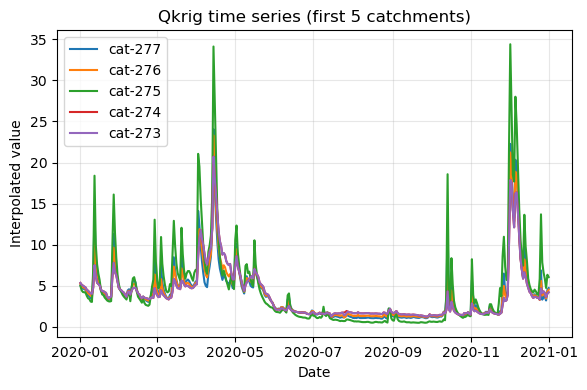

In [12]:
# pick the first 5 catchments
first5 = TS.columns[:5]

plt.figure(figsize=(6, 4))
for col in first5:
    plt.plot(TS.index, TS[col], label=col)

plt.title("Qkrig time series (first 5 catchments)")
plt.xlabel("Date")
plt.ylabel("Interpolated value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()